# Tutorial 1: Creating an isotherm for a zeolite absorbing carbon dioxide
## Author: Rhiannon Heath 

In this tutorial you will be setting up and running code to generate data in order to produce an isotherm for a typical zeolite absorbing carbon dioxide. To do this you will be calculating the number of molecules of carbon dioxide which absorb in the system, including uncertainties for a specified range of partial gas pressures or chemical potentials. You will do this by running the dlmontepython package simtask, in conjuction with running DL_MONTE to run the Monte Carlo simulations. 
Links to the dlmontepython and DL_MONTE page have been included here for your reference: 
https://gitlab.com/dl_monte/user-hub#about-the-dl_monte-project
https://gitlab.com/dl_monte/dlmontepython

### Prerequisites

1) Make sure that the correct dlmontepython library is installed, to do this go to the dlmontepython gitlab and follow the simtask tutorial - this is the dlmontepython package used in conjunction with DL_MONTE in order to run the Monte Carlo simulations and produce data along with their uncertainties to create the isotherm. It is highly recommended you follow this tutorial and learn about the simtask package before going any further with 'Tutorial 1'. 
The link to the dlmontepython gitlab in order to install the correct modules and hence be able to run simtask has been included below:
https://gitlab.com/dl_monte/dlmontepython/-/tree/master/examples/simtask/dlmonte_gcmc_lj
The link to install DL_MONTE to be able to run the Monte Carlo simulations has also been included here:
https://gitlab.com/dl_monte/user-hub#installing-the-program

2) Once the correct packages are installed, test simtask works by running the cell below - it has worked if no errors are produced once the code has run:

In [ ]:
import logging

import dlmontepython.simtask.dlmonteinterface as interface
import dlmontepython.simtask.measurement as measurement
import dlmontepython.simtask.analysis as analysis
import dlmontepython.simtask.task as task

You also need to make sure that DL_MONTE-SRL.X is in the system path, check this by running the cell below, it is in the correct place when the output runs "true"

3) Once you have tested both of the above work, the simtask package code 'fixedtimesweep' can then be used

4) The 'fixedtimesweep' code is shown below along with explanations of how the code works.

**NOTE:** By default in DL_MONTE the chemical potentialy is actually the thermodynamic activity given by the equation: a = exp(mu/(K_BT)). By using the line 'use gaspressure' in the CONTROL input file this gives the gas pressure (also known as fugacity) in Katm. 

**NOTE:** For the line in the code "nmol_obs = task.Observable( ("nmol",1) )", the nmol value needs to be 1 since this signifies the second molecular species in the system ie. carbon dioxide and hence this is what is tracked during the simulations, whereas 0 signifies the first species ie. the zeolite, and hence you want the number to be 1 so you track the number of carbon dioxde molecules rather than the zeolite. If you use the value of 0, the simulation does not run properly.

### Code for fixedtimesweep 

This code produces data for the number of molecules absorbed by the zeolite for a fixed time (and precision if desired - see NOTE below) at a specified chemical potential  

**WARNING** - The simulation may take some time to run so don't panic if it seems to take a long time!

In [ ]:
import logging

import dlmontepython.simtask.dlmonteinterface as interface
import dlmontepython.simtask.measurement as measurement
import dlmontepython.simtask.analysis as analysis
import dlmontepython.simtask.task as task

# This script performs multiple DL_MONTE simulations to calculate the mean and uncertainty in the energy and 
# number of molecules in the system reflected in the CONTROL, CONFIG and FIELD files in the current directory. 
#The simulations used to calculate the mean and uncertainty at each 
# temperature are constrained for convenience to take 30 seconds. 

# Make sure that the 'simtask' module is included the PYTHONPATH environment variable before executing this script,
# as well as Kevin Stratford's 'htk' module (which is imported by 'simtask')


# Set up the logger, which determines the nature of information output by the machinery in the 'simtask' package.
# The code below results in logging information being output to stdout

handler = logging.StreamHandler()

# Replacing 'logging.INFO' with 'logging.DEBUGGING' below results in more information being output by the
# logger. Using 'logging.WARNING' results in less information being output: only 'warnings'

measurement.logger.setLevel(logging.INFO)
measurement.logger.addHandler(handler)

# Set up the relevant TaskInterface object: which tells the low-level machinery in the 'simtask' package
# which code will be used to perform the simulations, and how to perform various tasks specific to that
# code, e.g. extracting the energy from output files created by the code.
# In this case we use DL_MONTE to perform our simulations; thus the TaskInterface object we will use
# is in fact a DLMonteInterface object (DLMonteInterface is a subclass of TaskInterface). The line
# below sets up a DL_MONTE-specific interface. Note that the interface must know the location of the 
# DL_MONTE executable - which is specified as the argument to the DLMonteInterface constructor.

interface = interface.DLMonteInterface("/Users/Rhiannon/bin/DLMONTE-SRL.X")

# Set up a list of 'observables' to track and analyse. Observables must be Observable objects, and the nature
# of Observable objects may vary between simulation codes. For DL_MONTE only observables corresponding to variables
# output periodically in YAMLDATA are currently supported. For a variable 'foo' specified in the YAMLDATA file
# the corresponding Observable object is returned by the command 'task.Observable( ("foo",) )'. Note the essential
# comma after "foo"! For a variable in YAMLDATA which is an array (e.g., 'nmol'), the observable corresponding to 
# the nth element in the array is returned by the command 'task.Observable( ("foo",n-1) )'. See below: 'energy_obs'
# corresponds to the 'energy' variable in YAMLDATA, and 'nmol_obs' corresponds to the 2nd element in the 'nmol'
# array in YAMLDATA (which in fact is the number of molecules belonging to the 2nd molecular species)

energy_obs = task.Observable( ("energy",) )
nmol_obs = task.Observable( ("nmol",1) )
observables = [ energy_obs, nmol_obs ]

# Set up a Measurement object which will determine the nature of the simulations and data analysis at each
# temperature. We specify that no more than 20 simulations will be performed (via the 'maxsims' argument), and 
# that the maximum time we will allow over all simulations at a given chemical potential is 30s (via the 'maxtime' 
# argument).

measurement_template = measurement.Measurement(interface, observables, maxsims=20, maxtime=30 )

# Set up the chemical potentials to consider

chempots = [ 0.0001, 0.00015, 0.0002, 0.00025, 0.0003 ]


# Set up a MeasurementSweep object which - which will actually perform the simulations and data analysis.
# Note that all the simulations and output files pertaining to analysis will be created in the directory
# 'Zeolite1' (via the 'outputdir' argument). Note also that the control parameter 'param' is set to 
# "temperature" while the list of control parameters to explore 'paramvalues' is set to the the temperatures
# mentioned above. The DLMonteInterface, linked to the MeasurementSweep object via 'interface' in 
# 'measurement_template', thus knows to treat the temperature in the CONTROL file as a control parameter, 
# and explore the temperatures in 'temperatures' accordingly

sweep = measurement.MeasurementSweep(param="molchempot", paramvalues=chempots, 
                                     measurement_template=measurement_template, outputdir="Zeolite1")

# Run the task

sweep.run()


# Once the task is complete in the 'Zeolite1' directory there will be directories 'param_0.0001', 'param_0.00015',
# etc. containing the data pertaining to each temperature. The contents of each of these directories is the
# same as described in 'fixedtime.py'. However the salient results are contained in the files 'energy_sweep.dat'
# and 'nmol_1_sweep.dat', which contain plots of, respectively, the energy and its uncertainty vs. temperature,
# and the number of molecules in the system and its uncertainty (which is proportional to the density of the system)
# vs. temperature. Note that the 'task' module automatically detects whether the system has equilibrated, and
# also automatically determines a block size to use in block averaging. Thus it is possible that a simulation at one
# of the considered temperatures does not equilibrate within the allowed simulation time, or that it does equilibrate
# and that there is not enough post-equilibration data to obtain the mean or uncertainty. If the mean, say, energy
# cannot be calculated at a given temperature then that temperature is omitted from 'energy_sweep.dat'. If the mean
# can be calculated but the uncertainty cannot (note that the uncertainty requires more post-equilibration to
# calculate) then the uncertainty is quoted in 'energy_sweep.dat' as 'NaN'



**NOTE:** It is possible to incorporate both the fixedtime and precision into the same code so that the simulation can run until either a certain precision is reached as long as it's within the maxtime specification, or it can run until the maxtime specification has been reached as the precision level has not been reached at this point. This can be done by adding the following line into the code above:

In [ ]:
precisions = { nmol_obs : 5 }

### Analysis

Once the data has been produced, in order to plot the isotherm, use the nmol.dat file and plot the partial pressure against the number of molecules. An example isotherm along with example data is shown below. 

**NOTE:** In order to obtain the data and the corresponding isotherm shown below the maxtime was increased to 300 seconds, and the precison parameter was set to 5 molecules. The number of steps used in the control file was 1000000. This was to ensure that for each chemical potential there were several short simulations to obtain better data, rather than only one long simulation.The code above will produce data for the chemical potentials 0.0001, 0.00015, 0.0002, 0.00025, 0.0003 - why not try inputting some different chemical potential values and see what results you get? 

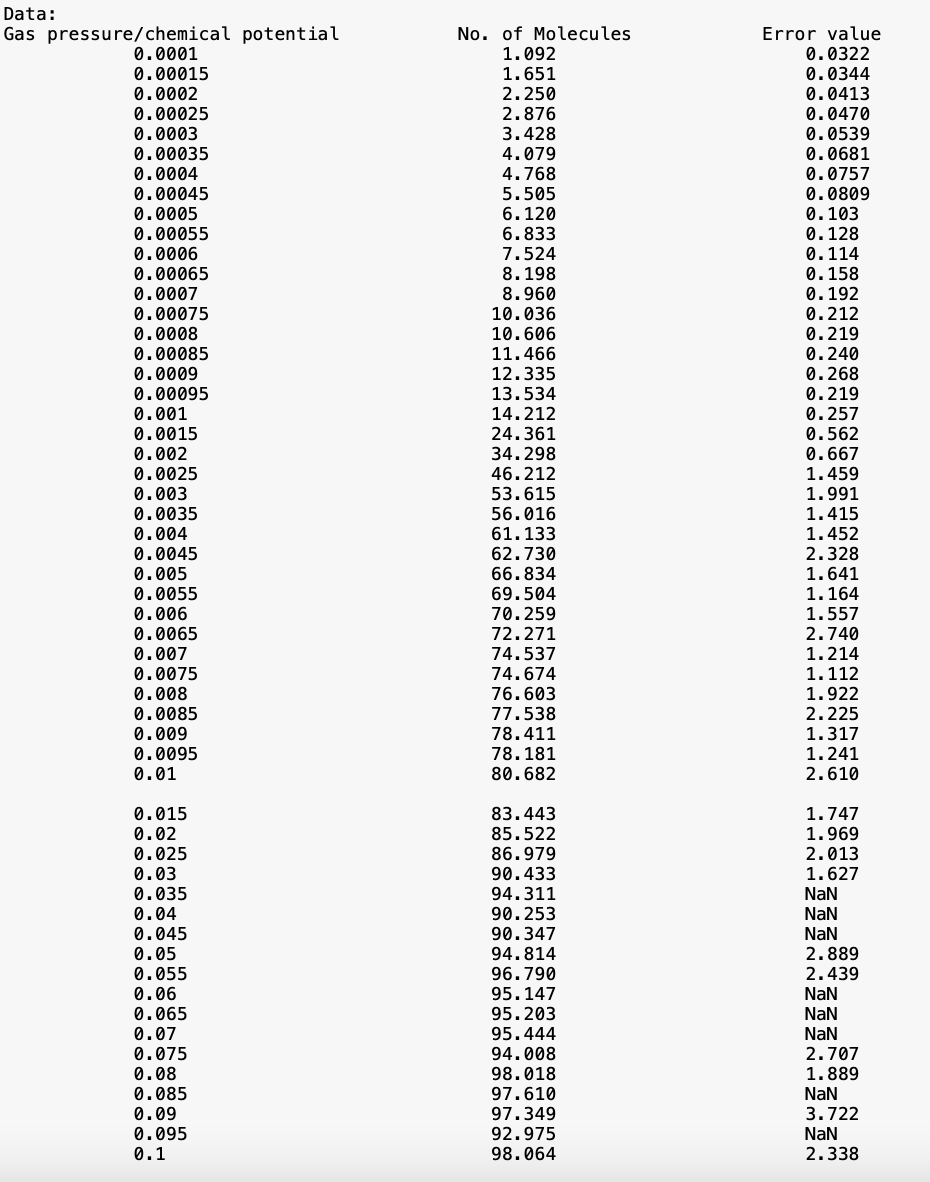

The above data produces the following isotherm shown below.  

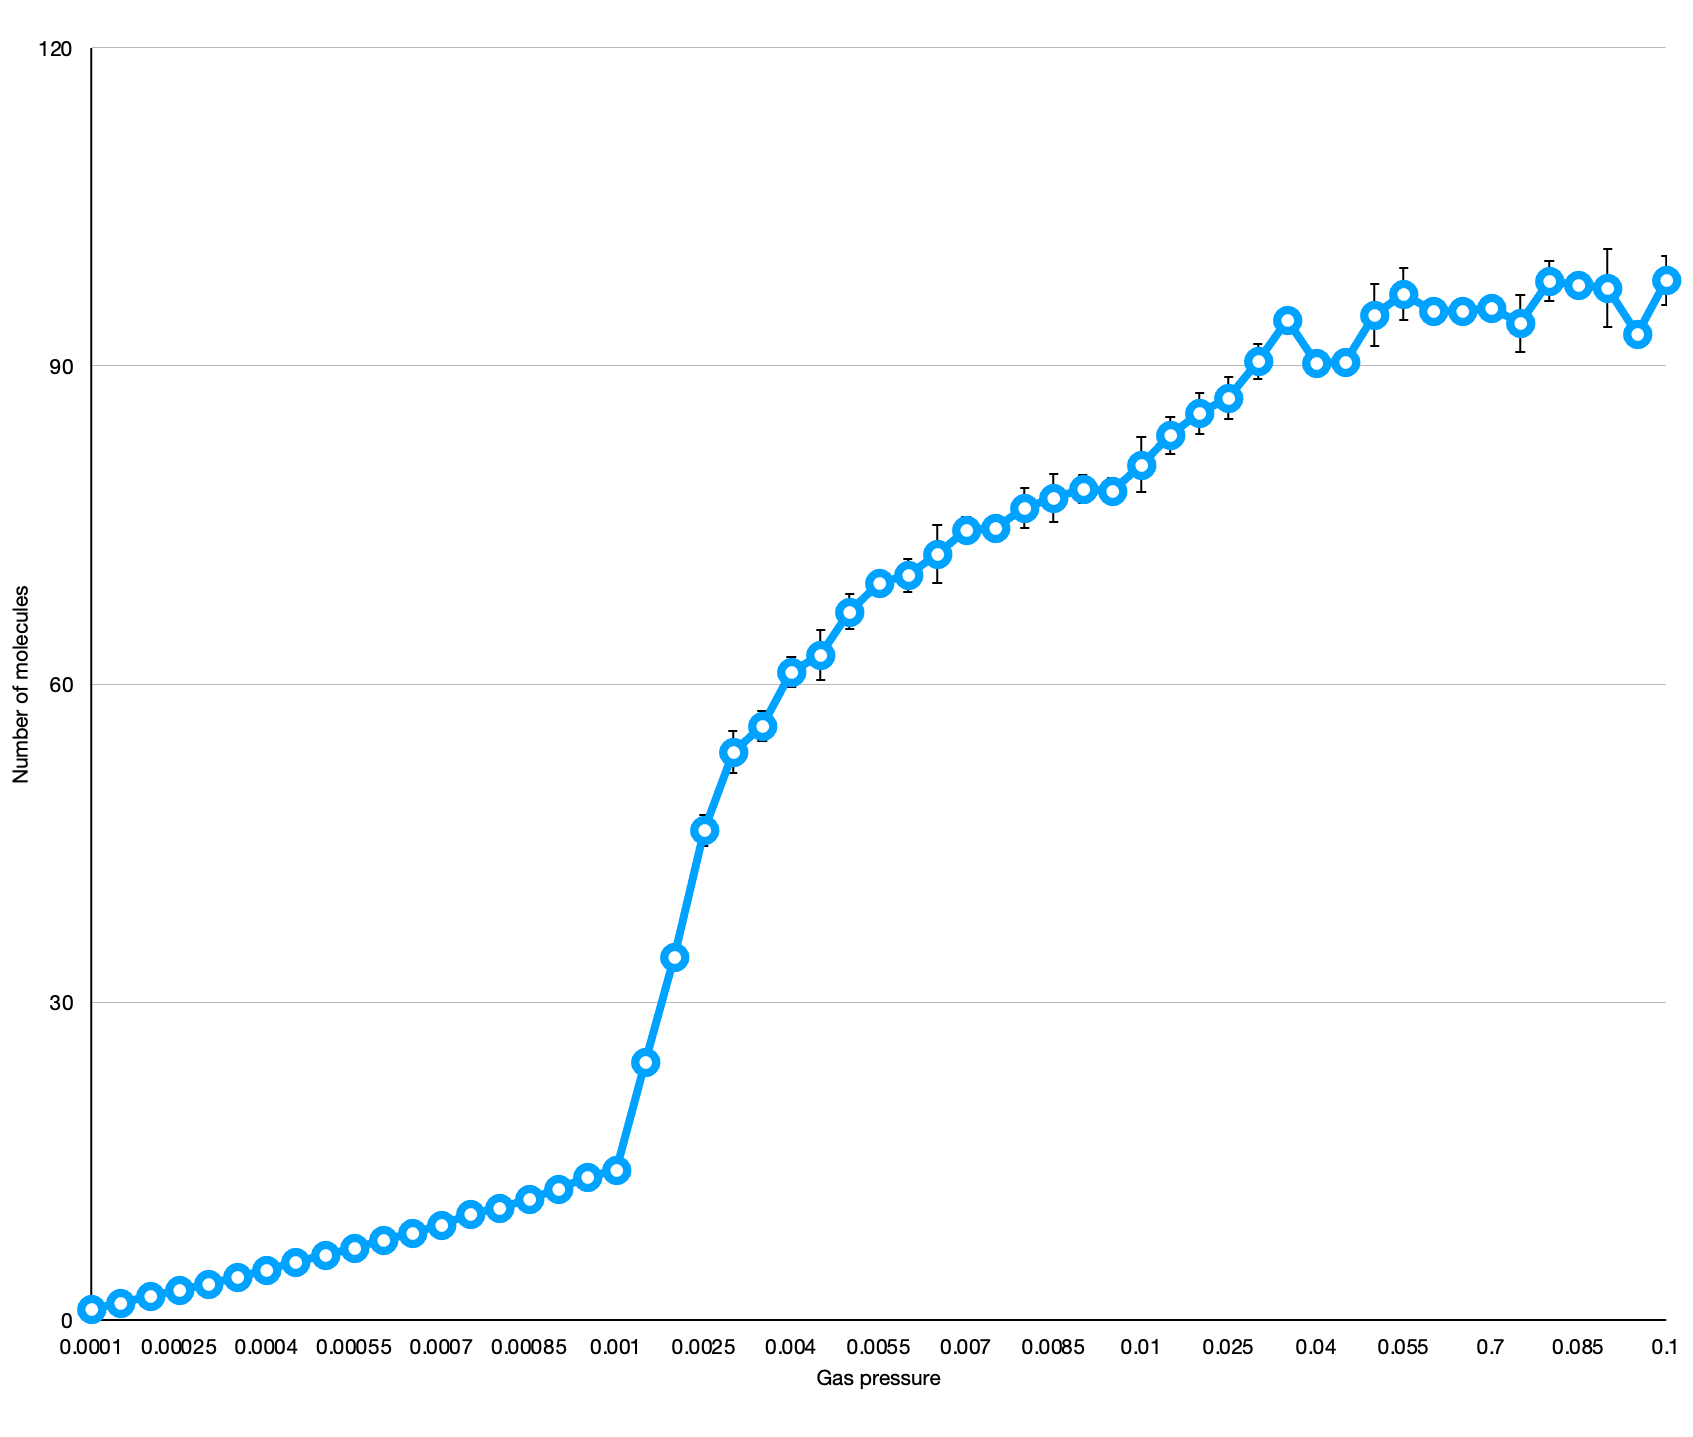

**NOTE:** Some of the errors for the data points are so small they are behind the markers and hence cannot be seen, some of the data points don't have errors since the simulation returned "NaN"

An example nmol.dat file, as well as an example output file for the values of 0.0001, 0.00015, 0.0002, 0.00025, 0.0003 and 0.00035 have been included for reference. 